# Clusteringsmodel Implementatie voor TransactionHistory Data


In dit notebook voeren we een clustering uit op de `TransactionHistory` dataset. We gebruiken KMeans clustering om clusters te identificeren op basis van de productinformatie, hoeveelheden, kosten en transactietypes. We zullen ook aanvullende analyses en visualisaties uitvoeren om de clusters te interpreteren

## Importeren van dependencies

In [19]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from db_utils.db_utils import create_connection, run_query, create_local_connection, run_local_query

## Inladen van de Data

In [20]:
conn = create_local_connection("AdventureWorks2019")
query = "SELECT * FROM PayHistory"
# payhistory_df = run_local_query("SELECT * FROM Production.TransactionHistory", "AdventureWorks2019")

df = run_local_query(query, "AdventureWorks2019")
df = df.head(10000)

c:\Users\lfatm\OneDrive\Documenten\deds_proj_groep1\db_utils\db_utils.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Data Voorbereiden

We selecteren de relevante variabelen en passen one-hot encoding toe op `TransactionType`

In [22]:
# Selecting the relevant independent variables for clustering
features = ['ProductID', 'Quantity', 'ActualCost', 'TransactionType']
data = df[features]

data = pd.get_dummies(data, columns=['TransactionType'])

## Data Standaariseren

We standaariseren de data om betere clustering prestaties te krijgen

In [23]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

## Bepalen van de Optimale `k`

We bepalen het optimale aantal clusters (k) door KMeans clustering toe te passen en de silhouette score, inter-cluster afstand en intra-cluster afstand te berekenen.

### Uitleg van de variabelen
- **intra_distance**: De gemiddelde aftand tussen punten binnen dezelfde cluster. Een lagere intra-cluster afstand duidt op meer compace clusters.
- **inter_distance**: De gemiddelde afstand tussen de centra van verschillende clusters. Een hogere inter-cluster afstand duidt op betere gescheiden clusters.
- **silhouette_score**: Een maat voor hoe dicht elk punt bij de punten in zijn eigen cluster ligt ten opzichte van punten in de dichtsbijzijnde andere cluster. De waarde varieert van -1 tot 1, waarbij een hogere waarde betere clustering aangeeft.

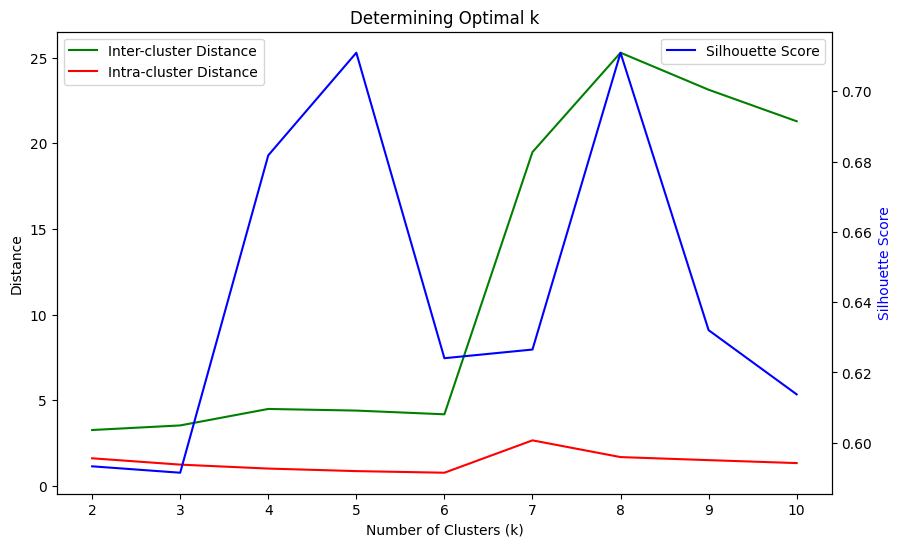

The optimal number of clusters is:
5.0
    k  inter_distance  intra_distance  silhouette_score
0   2        3.268473        1.617814          0.593296
1   3        3.536284        1.248798          0.591475
2   4        4.497833        1.018192          0.681763
3   5        4.402370        0.870326          0.710954
4   6        4.185498        0.776126          0.624052
5   7       19.488643        2.664951          0.626516
6   8       25.285794        1.688120          0.710919
7   9       23.126370        1.510464          0.632032
8  10       21.285890        1.338661          0.613768


In [33]:
# Function to calculate intra-cluster distance without pairwise_distances
def calculate_intra_distance(kmeans, data):
    distances = []
    for i in range(kmeans.n_clusters):
        cluster_points = data[kmeans.labels_ == i]
        if len(cluster_points) > 1:
            center = kmeans.cluster_centers_[i]
            distance = np.mean(np.linalg.norm(cluster_points - center, axis=1))
            distances.append(distance)
    intra_distance = np.mean(distances)
    return intra_distance

# Determine the optimal k
max_k = 10
results = []

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_scaled)
    intra_distance = calculate_intra_distance(kmeans, data_scaled)
    silhouette_avg = silhouette_score(data_scaled, kmeans.labels_)
    inter_distance = np.mean([np.linalg.norm(x - y) for i, x in enumerate(kmeans.cluster_centers_) for j, y in enumerate(kmeans.cluster_centers_) if i != j])
    results.append((k, inter_distance, intra_distance, silhouette_avg))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['k', 'inter_distance', 'intra_distance', 'silhouette_score'])

# Find the optimal k based on silhouette score
optimal_k = results_df.loc[results_df['silhouette_score'].idxmax()]['k']

# Plot de resultaten
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(results_df['k'], results_df['inter_distance'], 'g-', label='Inter-cluster Distance')
ax1.plot(results_df['k'], results_df['intra_distance'], 'r-', label='Intra-cluster Distance')
ax2.plot(results_df['k'], results_df['silhouette_score'], 'b-', label='Silhouette Score')

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Distance', color='black')
ax2.set_ylabel('Silhouette Score', color='b')

plt.title('Determining Optimal k')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

print(f'The optimal number of clusters is:')
print(optimal_k)

print(results_df)

## Toepassen van KMeans met Optimale `k`

We passen KMeans clustering toe met de optimale waarde van k en voegen clusterlabelstoe aan de oorspronkelijke dataset

In [25]:
# Final KMeans model with optimal k
kmeans_optimal = KMeans(n_clusters=int(optimal_k), random_state=42)
kmeans_optimal.fit(data_scaled)

# Assign cluster labels to the original dataframe
df['Cluster'] = kmeans_optimal.labels_

# Save the clustered data to a new table in the database
conn = sqlite3.connect('cluster_model.db')
df.to_sql('TransactionHistoryClustered', conn, if_exists='replace', index=False)
conn.close()

## Aanvullende Analyses en Visualisaties

We analyseren de clusterprofielen en visualiseren de clusters met PCA

Cluster Profiles:
                 IDSK  TransactionID   ProductID  ReferenceOrderID  \
Cluster                                                             
0        4393.160257  104392.160257  875.436706      53902.992078   
1        6476.745614  106475.745614  859.357310      42730.325146   
2        3733.268959  103732.268959  851.654196      53805.976744   
3        7219.201278  107218.201278  509.063898        554.538339   
4        6656.142857  106655.142857  419.448052      42814.056818   

         ReferenceOrderLineID    Quantity   ActualCost  Cluster  
Cluster                                                          
0                   11.431094    2.581284   142.630602      0.0  
1                    0.000000   30.540351     0.000000      1.0  
2                   13.183013    2.463094  1675.212610      2.0  
3                    2.646965  244.071885    34.794518      3.0  
4                    0.000000  289.875000     0.000000      4.0  


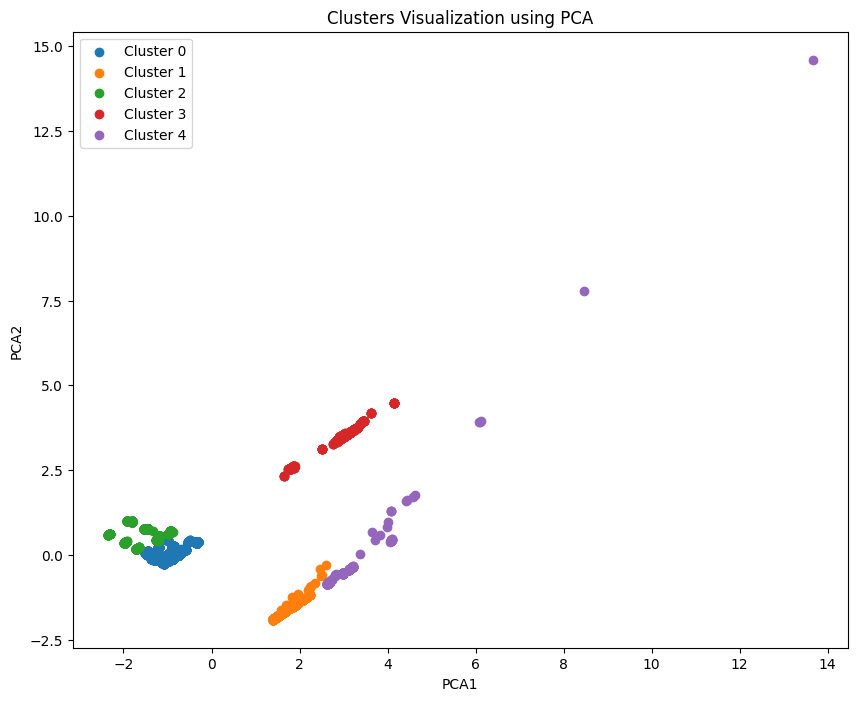

In [27]:
# Analyze cluster profiles
numeric_columns = df.select_dtypes(include=np.number).columns
cluster_profiles = df.groupby('Cluster')[numeric_columns].mean()
print("Cluster Profiles:\n", cluster_profiles)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
df['PCA1'] = data_pca[:, 0]
df['PCA2'] = data_pca[:, 1]

plt.figure(figsize=(10, 8))
for cluster in range(int(optimal_k)):
    subset = df[df['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters Visualization using PCA')
plt.legend()
plt.show()


## Evaluatie van Clusters over tijd

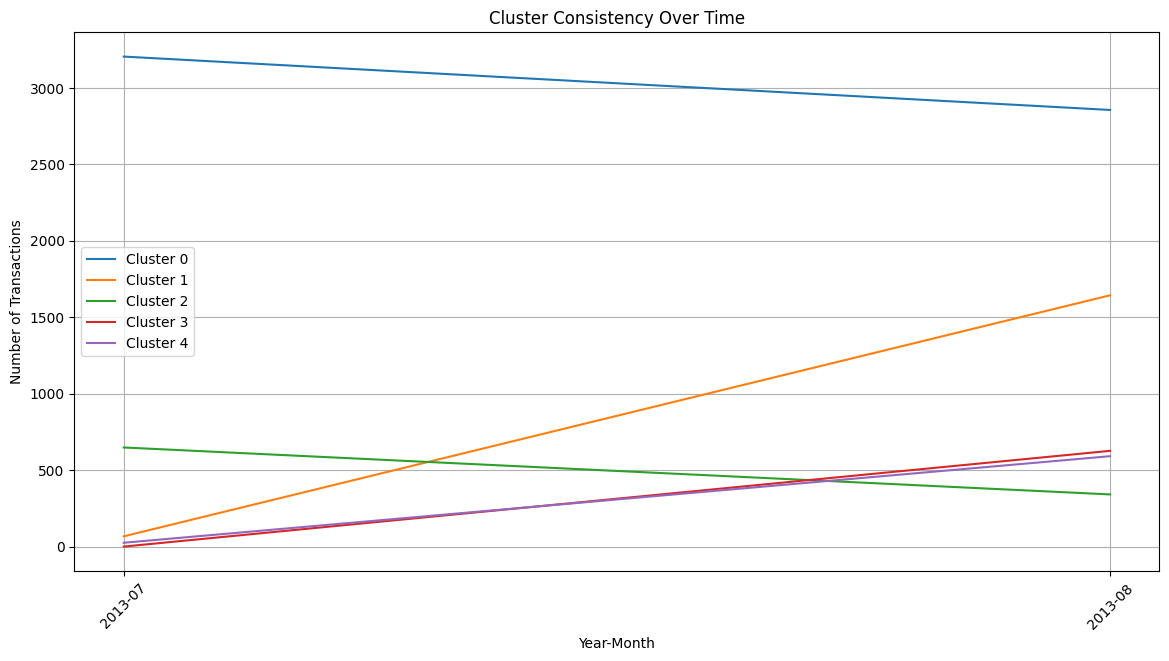

In [31]:
if 'TransactionDate' in df.columns:
    # Converteer 'TransactionDate' naar datetime objecten en maak een nieuwe kolom 'YearMonth' aan
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
    df['YearMonth'] = df['TransactionDate'].dt.to_period('M')
    
    # Groepeer de data op 'YearMonth' en 'Cluster' en bereken het aantal transacties per cluster per maand
    cluster_trend = df.groupby(['YearMonth', 'Cluster']).size().unstack(fill_value=0)
    
    # Zet de Period objecten om naar strings
    cluster_trend.index = cluster_trend.index.strftime('%Y-%m')
    
    # Plot de cluster consistentie over tijd
    plt.figure(figsize=(14, 7))
    for cluster in cluster_trend.columns:
        plt.plot(cluster_trend.index, cluster_trend[cluster], label=f'Cluster {cluster}')
    plt.title('Cluster Consistency Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Transactions')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Roteren van x-labels voor betere leesbaarheid
    plt.show()


## Interpretatie van de Plot

De grafiek toont de consistentie van clusters over tijd voor de transacties in de dataset. Elke lijn vertegenwoordigt een cluster en de x-as toont de maanden in het formaat 'YYYY-MM'. De y-as geeft het aantal transacties weer dat in elk cluster plaatsvond gedurende elke maand.

### Wat zien we?

- **Clusterpatronen over tijd**: Door de lijnen van verschillende clusters te volgen, kunnen we zien hoe de transacties in elk cluster in de loop van de tijd variëren. We kunnen patronen identificeren zoals seizoensgebonden fluctuaties, trends en uitschieters.

- **Clusterstabiliteit**: Een gelijkmatige verdeling van transacties over clusters gedurende de tijd duidt op een hoge stabiliteit van de clusters. Als bepaalde clusters aanzienlijke schommelingen vertonen in het aantal transacties, kan dit wijzen op veranderingen in het gedrag van klanten of andere externe factoren.

- **Identificatie van significante gebeurtenissen**: Opvallende pieken of dalen in het aantal transacties binnen bepaalde clusters kunnen wijzen op specifieke gebeurtenissen, promoties, campagnes of seizoensinvloeden die van invloed zijn op het koopgedrag van klanten.


## Aanvullende Statistieken per Cluster


We berekenen aanvullende statistieken zoals de gemiddelde en totale hoeveelheden en kosten per cluster.


In [29]:
# Additional statistics per cluster
cluster_stats = df.groupby('Cluster').agg({
    'Quantity': ['mean', 'sum'],
    'ActualCost': ['mean', 'sum']
})
print("Cluster Statistics:\n", cluster_stats)


Cluster Statistics:
            Quantity           ActualCost              
               mean     sum         mean           sum
Cluster                                               
0          2.581284   15640   142.630602  8.641988e+05
1         30.540351   52224     0.000000  0.000000e+00
2          2.463094    2436  1675.212610  1.656785e+06
3        244.071885  152789    34.794518  2.178137e+04
4        289.875000  178563     0.000000  0.000000e+00
